# André Fonseca
# Trabalho de conclusão do Data Science - Awari
# Análise derivado do LISH-MoA
## https://www.kaggle.com/c/lish-moa/overview


The Connectivity Map, a project within the Broad Institute of MIT and Harvard, the Laboratory for Innovation Science at Harvard (LISH), and the NIH Common Funds Library of Integrated Network-Based Cellular Signatures (LINCS), present this challenge with the goal of advancing drug development through improvements to MoA prediction algorithms.

#### What is the Mechanism of Action (MoA) of a drug? And why is it important?

In the past, scientists derived drugs from natural products or were inspired by traditional remedies. Very common drugs, such as paracetamol, known in the US as acetaminophen, were put into clinical use decades before the biological mechanisms driving their pharmacological activities were understood. Today, with the advent of more powerful technologies, drug discovery has changed from the serendipitous approaches of the past to a more targeted model based on an understanding of the underlying biological mechanism of a disease. In this new framework, scientists seek to identify a protein target associated with a disease and develop a molecule that can modulate that protein target. As a shorthand to describe the biological activity of a given molecule, scientists assign a label referred to as mechanism-of-action or MoA for short.

#### How do we determine the MoAs of a new drug?

One approach is to treat a sample of human cells with the drug and then analyze the cellular responses with algorithms that search for similarity to known patterns in large genomic databases, such as libraries of gene expression or cell viability patterns of drugs with known MoAs.

In this competition, you will have access to a unique dataset that combines gene expression and cell viability data. The data is based on a new technology that measures simultaneously (within the same samples) human cells’ responses to drugs in a pool of 100 different cell types (thus solving the problem of identifying ex-ante, which cell types are better suited for a given drug). In addition, you will have access to MoA annotations for more than 5,000 drugs in this dataset.

As is customary, the dataset has been split into testing and training subsets. Hence, your task is to use the training dataset to develop an algorithm that automatically labels each case in the test set as one or more MoA classes. Note that since drugs can have multiple MoA annotations, the task is formally a multi-label classification problem.

#### How to evaluate the accuracy of a solution?

Based on the MoA annotations, the accuracy of solutions will be evaluated on the average value of the logarithmic loss function applied to each drug-MoA annotation pair. If successful, you’ll help to develop an algorithm to predict a compound’s MoA given its cellular signature, thus helping scientists advance the drug discovery process.

# 1. Import modules

In [ ]:
!pip install scikit-multilearn

In [ ]:
!pip install python-louvain

In [ ]:
!pip install networkx

In [ ]:
!pip install fastcluster

In [17]:
# Basic
import pandas as pd
import numpy as np
import random 
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing and Model Selection
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler

# PCA and T-SNE
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Clustering
import fastcluster
import networkx as nx
import community
from skmultilearn.cluster import LabelCooccurrenceGraphBuilder
from skmultilearn.cluster import NetworkXLabelGraphClusterer

# Stats
from scipy import stats

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/My Drive/Awari

# 2. Loading dataset

### Files description

**train_features.csv** - Features for the training set. Features g- signify gene expression data, and c- signify cell viability data. cp_type indicates samples treated with a compound (cp_vehicle) or with a control perturbation (ctrl_vehicle); control perturbations have no MoAs; cp_time and cp_dose indicate treatment duration (24, 48, 72 hours) and dose (high or low).

**train_targets_scored.csv** - The binary MoA targets that are scored.

**train_targets_nonscored.csv** - Additional (optional) binary MoA responses for the training data. These are not predicted nor scored.

**test_features.csv** - Features for the test data. You must predict the probability of each scored MoA for each row in the test data.

**sample_submission.csv** - A submission file in the correct format.

In [2]:
train_features = pd.read_csv("./data/train_features.csv")
test_features = pd.read_csv("./data/test_features.csv")

In [3]:
train_features.shape

(23814, 876)

In [4]:
train_targets_sc = pd.read_csv("./data/train_targets_scored.csv")
train_targets_ns = pd.read_csv("./data/train_targets_nonscored.csv")

In [5]:
sample_submission = pd.read_csv("./data/sample_submission.csv")

In [6]:
train_targets_sc.head(1)

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
train_features.head(1)

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.062,0.5577,-0.2479,-0.6208,-0.1944,-1.012,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176


In [8]:
sample_submission.head(1)

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_0004d9e33,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5


# 3. Dataset description and plotting

## 3.1. Training set statistics and dimension 

In [77]:
cell_columns = [col for col in train_features.columns if col.startswith('c-')]
gene_columns = [col for col in train_features.columns if col.startswith('g-')]

n_cell = len(cell_columns)
n_gene = len(gene_columns)

print(f'Número de células {n_cell} e números de genes {n_gene} avaliados no estudo.')

Número de células 100 e números de genes 772 avaliados no estudo.


In [78]:
samples, features = train_features.shape
print(f'O conjunto de dados têm {samples} e {features} amostras e atributos, respectivamente.')

O conjunto de dados têm 23814 e 876 amostras e atributos, respectivamente.


In [79]:
treatment = train_features.groupby('cp_type').size().reset_index(name = 'counts')
dosage = train_features.groupby(['cp_type', 'cp_dose']).size().reset_index(name='counts')
time = train_features.groupby(['cp_type', 'cp_time']).size().reset_index(name='counts')

/home/andrefonseca/anaconda3/lib/python3.6/site-packages/pandas/compat/_optional.py:124: UserWarning: Pandas requires version '2.6.2' or newer of 'numexpr' (version '2.6.1' currently installed).
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='cp_type', ylabel='counts'>

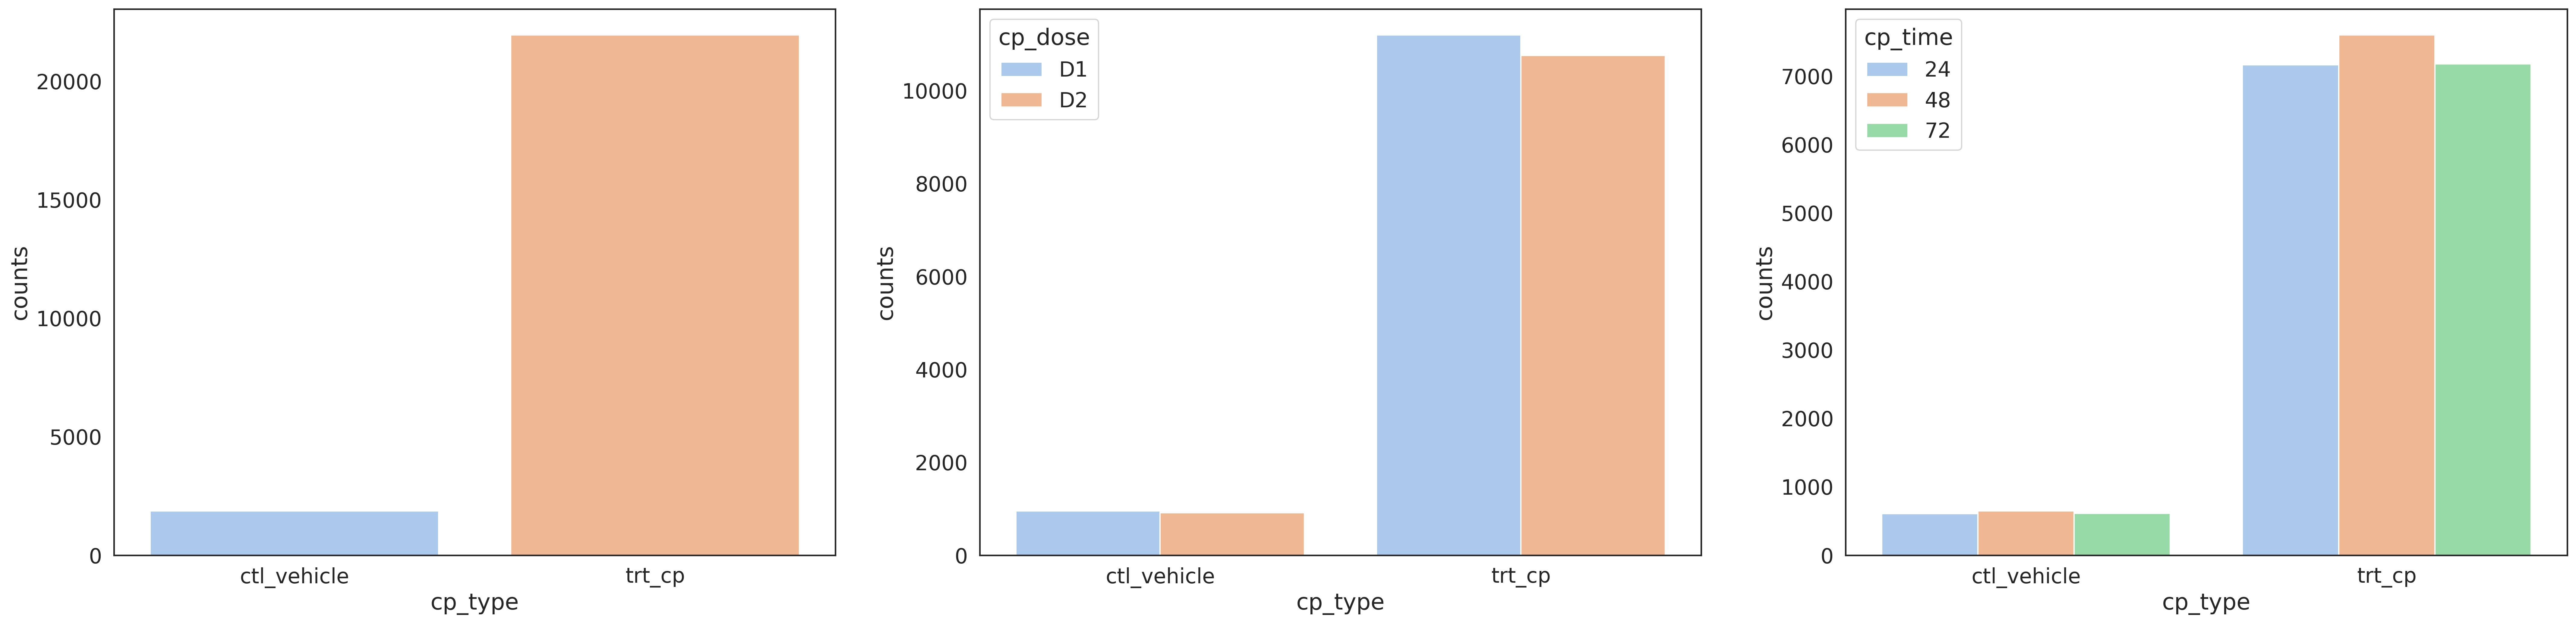

In [80]:
sns.set(style = "white", palette = "pastel", font_scale = 1.5, color_codes = True)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (35, 8), dpi = 300)

sns.barplot(x = "cp_type", y = "counts", data = treatment, ax = ax1)
sns.barplot(x = "cp_type", y = "counts", hue = 'cp_dose', data = dosage, ax = ax2)
sns.barplot(x = "cp_type", y = "counts", hue = 'cp_time', data = time, ax = ax3)

# Como remover tiulo de todos os eixos X

## 3.2. Verifying and summarising labels

In [81]:
n_pathways = [pathway for pathway in train_targets_sc.columns if pathway != "sig_id"]

In [82]:
print(f'Number of evaluate pathways {len(n_pathways)}')

Number of evaluate pathways 206


In [83]:
train_sc_pivot = pd.melt(train_targets_sc, id_vars=['sig_id'], value_vars = n_pathways,
                         var_name = 'pathways', value_name = 'counts')

In [84]:
train_sc_pivot = train_sc_pivot[train_sc_pivot['counts'] > 0]

In [85]:
train_classes = train_sc_pivot.groupby('pathways').sum().reset_index()
train_classes = train_classes.sort_values('counts')

### Is it really a multi-label problem?

In [86]:
pathway_head = train_classes['pathways'].head(10)
pathway_tail = train_classes['pathways'].tail(10)

In [87]:
pathway_subset = pd.concat([pathway_head, pathway_tail])
len(pathway_subset)

20

In [88]:
random.seed(10)
sample_subset = random.sample(list(train_sc_pivot.sig_id), 50)

In [89]:
train_sc_pathway = train_sc_pivot[train_sc_pivot['pathways'].isin(pathway_subset)]

In [90]:
train_sc_pathway = train_sc_pathway[train_sc_pathway['sig_id'].isin(sample_subset)]

In [91]:
path_short = train_sc_pathway.pathways.unique()
path_label = [path.split('_')[0].capitalize() for path in path_short]

In [92]:
sample_id = train_sc_pathway.sig_id.unique()

### All treatments activated multiples MoAs?

In [93]:
treatment_n_pathway = train_sc_pivot.groupby('sig_id').size().reset_index(name = 'MoAs')
treatment_n_pathway['MoAs'] = treatment_n_pathway['MoAs'].map(lambda x: '>5' if x >= 5 else x)
treatment_n_pathway = treatment_n_pathway.groupby('MoAs').size().reset_index(name = 'counts')

In [94]:
treatment_n_pathway['normalize'] = treatment_n_pathway['counts'] / sum(treatment_n_pathway['counts'])

### Is there a MoAs that occur more frequently?

In [95]:
train_classes['log10'] = np.log10(train_classes['counts'])
train_classes['ngroup'] = pd.qcut(train_classes['log10'], q = 20, labels = range(1, 21))

In [ ]:
plt.figure(figsize=(20, 16))
sns.set_style("whitegrid")

#
plt.subplot(1, 2, 1)
sns.scatterplot(x = "pathways", y = "sig_id", data = train_sc_pathway, s=200, color = '.2')

plt.xticks(path_short, path_label, rotation = 90)
plt.xlabel('MoA Pathways')

plt.yticks(sample_id, range(0, len(sample_id) + 1), fontsize = 10)
plt.ylabel('Treatments')

#
plt.subplot(2, 2, 2)
moa_barplot = sns.barplot(x = 'MoAs', y = 'normalize', data = treatment_n_pathway)
for p in moa_barplot.patches:
    moa_barplot.annotate(format(p.get_height() * 14447 , '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.ylabel('Treatments (%)')
plt.xlabel('# of MoAs')

#
plt.subplot(2, 2, 4)
sns.barplot(x = 'ngroup', y = 'counts', data = train_classes, palette='viridis')
plt.ylabel('# of Treatments')
plt.xlabel('MoA bins based on frequency')

plt.tight_layout()
plt.show()

***Is it really a multi-label problem?*** A: Yes, it is!

***All treatments activated multiples MoAs?***
A: Virtually all treatments are MoA-specific, which means that most of the drugs are acting in a single metabolic pathway per assay.

***Is there a MoAs that occur more frequently?***
A: There is a predominance of drug trials that act on a small group of metabolic pathways, such as NFKB and proteasome.

## 3.3 Labels to Network

In [37]:
X_train = train_features.drop('sig_id', axis = 1)
X_train = pd.get_dummies(X_train)

In [38]:
y_train = train_targets_sc.drop('sig_id', axis = 1)
label_names = y_train.columns

In [39]:
graph_builder = LabelCooccurrenceGraphBuilder(weighted=True, include_self_edges=False)

In [40]:
edge_map = graph_builder.transform(y_train.values)
print("{} labels, {} edges".format(len(label_names), len(edge_map)))

206 labels, 186 edges


In [143]:
clusterer = NetworkXLabelGraphClusterer(graph_builder, method = 'label_propagation')

In [144]:
partition = clusterer.fit_predict(X_train, y_train.values)

In [145]:
print('There are', len(partition),'clusters')

There are 124 clusters


In [177]:
cluster_map = {'cluster_name':[], 'pathways':[]}

In [178]:
for n, module in enumerate(partition):
    n = 'Cluster_' + str(n)
    if len(module) == 1:
        n = 'Uncluster'
    for vertices in module:
        cluster_map['cluster_name'].append(n)
        cluster_map['pathways'].append(label_names[vertices])

In [179]:
cluster_map = pd.DataFrame.from_dict(cluster_map)

In [180]:
cluster_map.cluster_name.unique()

array(['Uncluster', 'Cluster_1', 'Cluster_3', 'Cluster_4', 'Cluster_6',
       'Cluster_8', 'Cluster_9', 'Cluster_10', 'Cluster_14', 'Cluster_15',
       'Cluster_17', 'Cluster_19', 'Cluster_29', 'Cluster_30',
       'Cluster_35', 'Cluster_40', 'Cluster_41', 'Cluster_45',
       'Cluster_47', 'Cluster_53', 'Cluster_81', 'Cluster_90',
       'Cluster_95', 'Cluster_100', 'Cluster_109'], dtype=object)

In [181]:
cluster_map = cluster_map.sort_values(by = ['cluster_name'])

In [197]:
cluster_map.head(10)

,cluster_name,pathways
1,Cluster_1,11-beta-hsd1_inhibitor
2,Cluster_1,atp_synthase_inhibitor
3,Cluster_1,atpase_inhibitor
4,Cluster_1,acetylcholinesterase_inhibitor
5,Cluster_1,tubulin_inhibitor
6,Cluster_1,dihydrofolate_reductase_inhibitor
7,Cluster_1,dna_alkylating_agent
8,Cluster_1,dna_inhibitor
9,Cluster_1,thymidylate_synthase_inhibitor
49,Cluster_10,aldehyde_dehydrogenase_inhibitor


In [212]:
cluster_counts = cluster_map.groupby('cluster_name').size().reset_index()
cluster_counts.columns = ['cluster_name', 'n_pathways']

In [216]:
cluster_counts = cluster_counts.sort_values(by = 'n_pathways')

In [217]:
cluster_counts.tail()

,cluster_name,n_pathways
5,Cluster_15,7
0,Cluster_1,9
19,Cluster_8,9
21,Cluster_9,19
24,Uncluster,100


In [184]:
with open('./data/clusterer.pkl','wb') as outfile:
  pickle.dump(clusterer, outfile)

## 3.4. More about labels...

### Are the classes unbalanced?

In [ ]:
train_classes['percentage'] = (train_classes['counts'] * 100) / sum(train_classes['counts'])

In [ ]:
plt.figure(figsize = (35, 8))
sns.barplot(x = 'pathways', y = 'percentage', data = train_classes.tail(45))

plt.title('MoA Frequecy - TOP 45')
plt.xticks(rotation = 90)
plt.xlabel('')
plt.ylabel('Train set (%)')

### Is drug discovery biased to a chemical category?

In [ ]:
train_classes['drug_category'] = train_classes['pathways'].map(lambda x: x.split('_')[-1])

In [ ]:
train_category_counts = train_classes.groupby('drug_category').size().reset_index(name = 'counts')
train_category_counts.describe().T

In [ ]:
train_category_counts['percentage'] = (train_category_counts['counts'] * 100) / sum(train_category_counts['counts'])
train_category_counts = train_category_counts.sort_values('percentage')

In [ ]:
plt.figure(figsize = (35, 8))
sns.barplot(x = 'drug_category', y = 'percentage', data = train_category_counts)
plt.xticks(rotation = 90)

plt.ylabel('Drugs category (%)')
plt.xlabel('')

# 4. Overall patterns and features correlations

## 4.1. Gene and cell viability correlations

In [ ]:
# Compute the gene correlation matrix

gene_matrix = train[gene_columns]
gene_correlation = gene_matrix.corr()

# Compute the cell correlation matrix

cell_matrix = train[cell_columns]
cell_correlation = cell_matrix.corr()

In [ ]:
plt.figure(figsize = (35, 22))
sns.set_style("whitegrid")

#
plt.subplot(1, 2, 1)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(gene_correlation.iloc[0:50, 0:50], dtype=bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(gene_correlation.iloc[0:50, 0:50], mask = mask, cmap = cmap, vmax = 0.3, center = 0,
            square = True, linewidths = 0.5, cbar_kws={"shrink": .5})
plt.title('Gene correlation (TOP 50)')

#
plt.subplot(1, 2, 2)

mask = np.triu(np.ones_like(cell_correlation, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(cell_correlation, mask = mask, cmap = cmap, vmax = 0.3, center = 0,
            square = True, linewidths = 0.5, cbar_kws={"shrink": .5})
plt.title('Cells correlation (All)')

## 4.2. Double-checking cell viability distribution

In [ ]:
random.seed(10)

cell_subset = random.sample(cell_columns, 10)
cell_matrix_subset = train.loc[:, ['cp_type'] + cell_subset]

In [ ]:
g = sns.pairplot(cell_matrix_subset, hue = 'cp_type', plot_kws={'alpha':0.1}) 
g.fig.suptitle("Cell viability distribution", y=1.08)

# 5. Feature selection based on MoA

In [ ]:
train_gene_matrix = train[['sig_id'] + gene_columns]
train_gene_matrix.head(1)

In [ ]:
train_gene_matrix = pd.merge(train_gene_matrix, train_sc_pivot[['sig_id', 'pathways']], on='sig_id')
train_gene_matrix = train_gene_matrix.sort_values(by = 'pathways')

## 5.1. The treatment and other categorical features change gene expression per MoA?

## 5.2. Clustering gene expression per MoA

In [233]:
train_pathway_matrix = train_gene_matrix.drop(columns = ['sig_id', 'cp_time'], axis = 1)
train_pathway_matrix = train_pathway_matrix.groupby(['pathways']).mean()

In [235]:
train_pathway_matrix.shape

(206, 772)

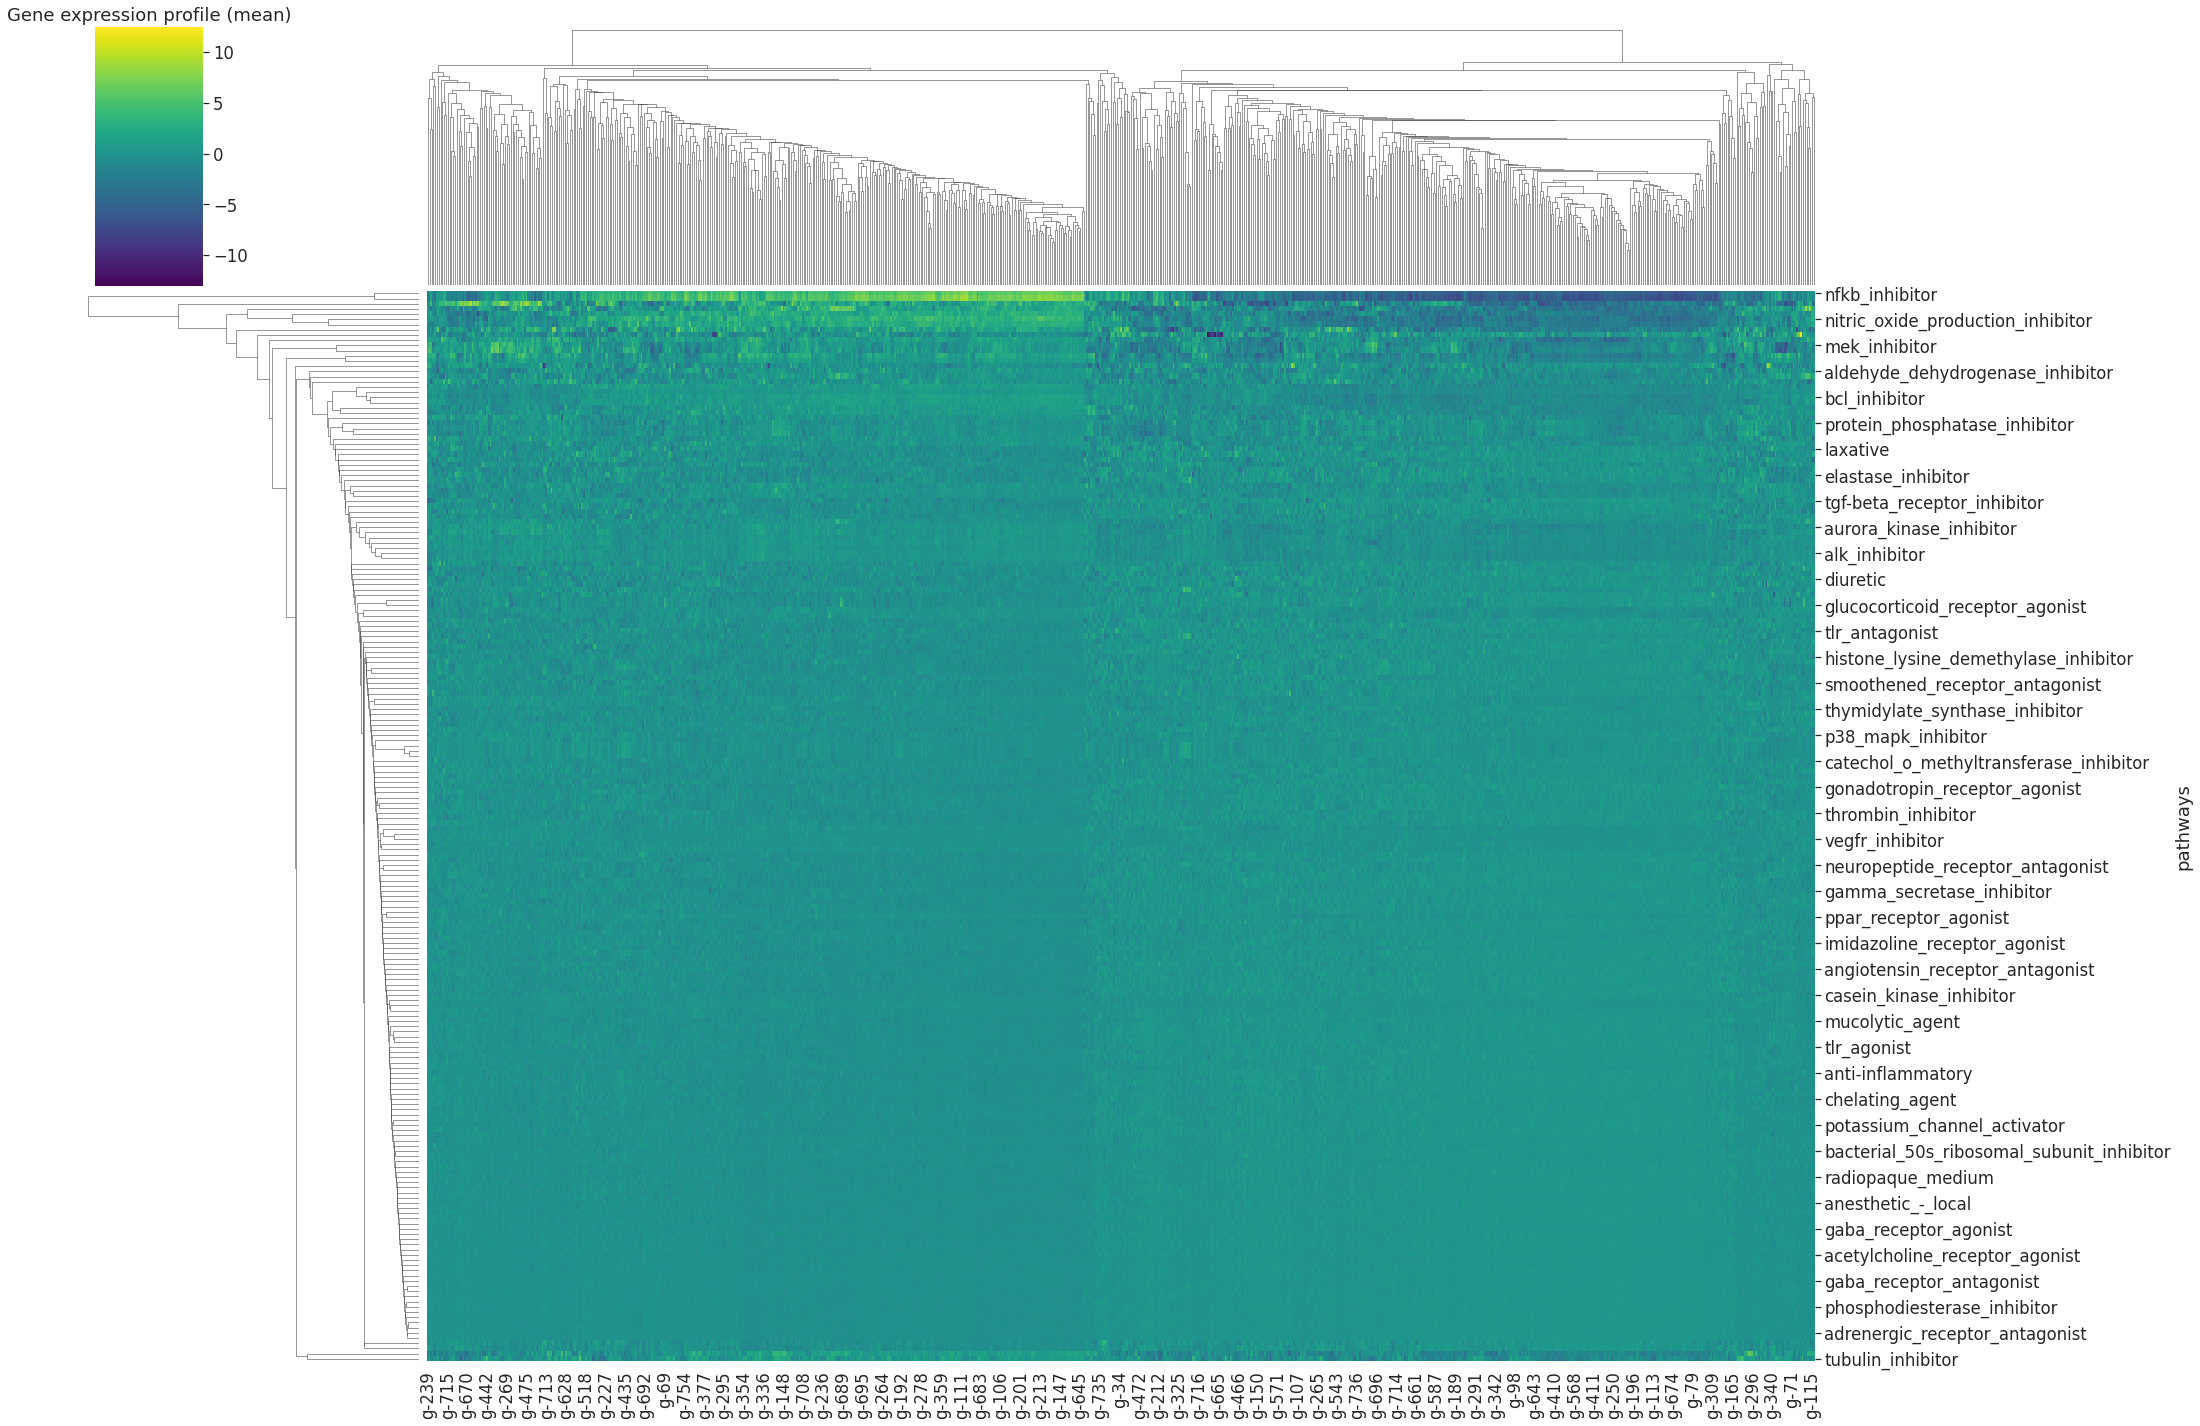

In [313]:
sns.clustermap(train_pathway_matrix, z_score = 1, figsize = (30, 20), cmap = "viridis")
plt.title('Gene expression profile (mean)', loc = 'center');

In [237]:
# Variance Threshold

In [307]:
variance = VarianceThreshold(threshold=0.25)

In [309]:
variance.fit(train_pathway_matrix)

VarianceThreshold(threshold=0.25)

In [310]:
train_pathway_variance = train_pathway_matrix.loc[:, variance.get_support()]

In [311]:
train_pathway_variance.shape

(206, 261)

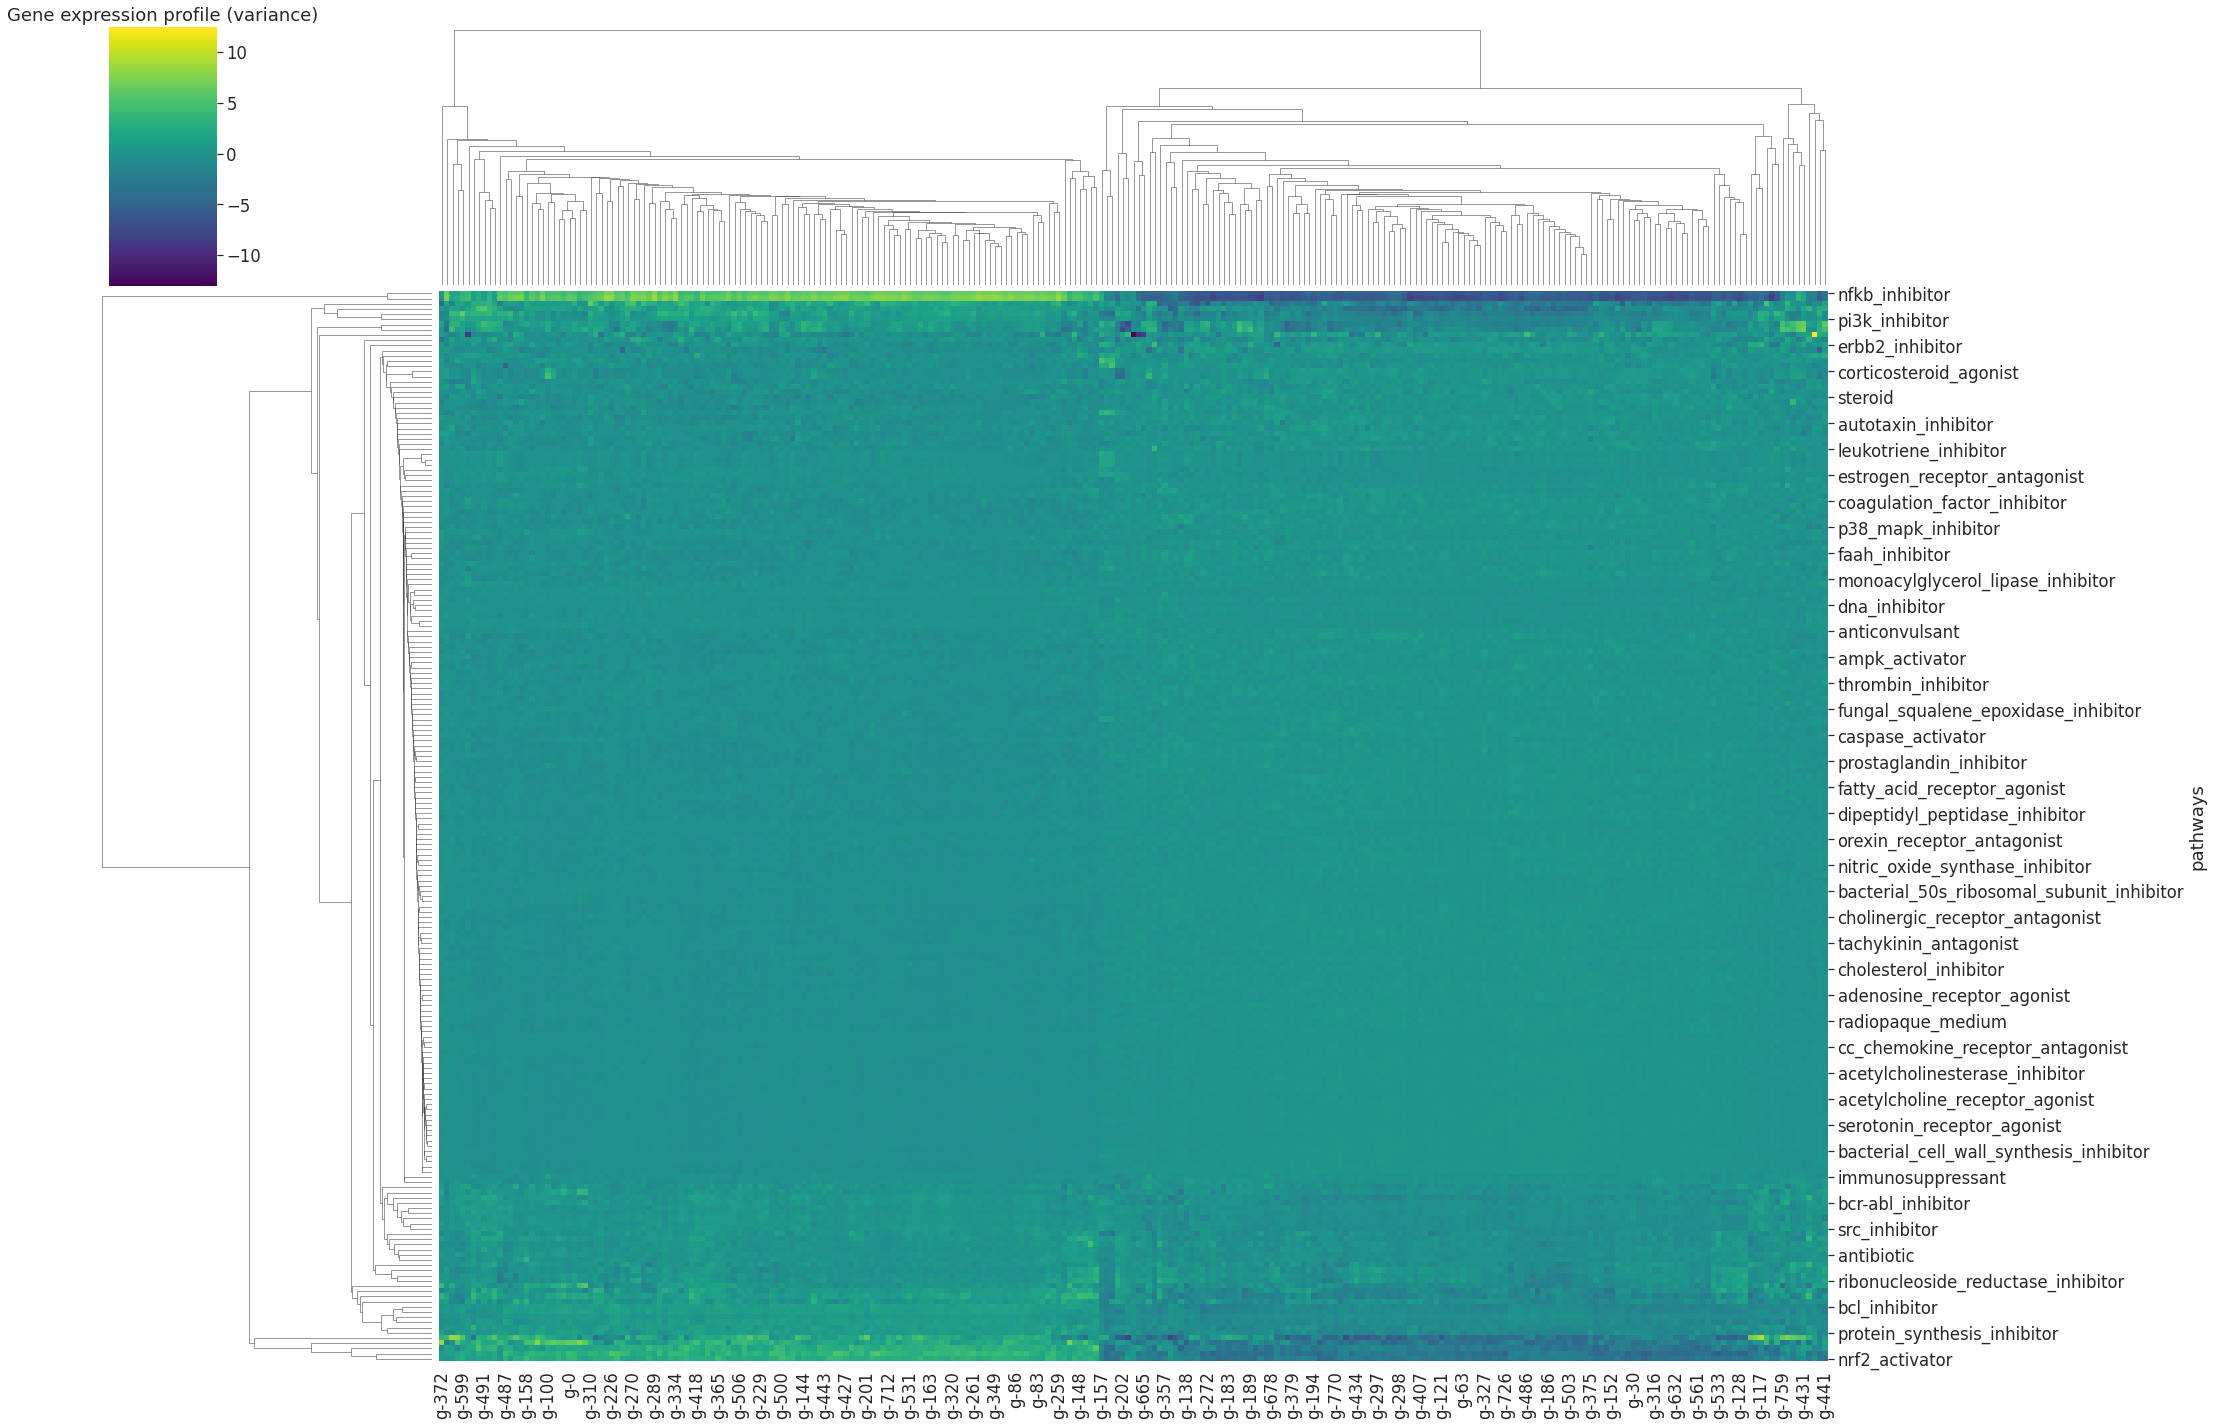

In [314]:
sns.clustermap(train_pathway_variance, z_score = 1, figsize = (30, 20), cmap = "viridis")
plt.title('Gene expression profile (variance)', loc = 'center');

# 6. Dimensionality Reduction - PCA

In [186]:
train_gene_matrix = train_features[['sig_id', 'cp_type', 'cp_time', 'cp_dose'] + gene_columns]
train_gene_matrix = pd.merge(train_gene_matrix, train_sc_pivot[['sig_id', 'pathways']], on = 'sig_id')

In [187]:
train_gene_matrix = pd.merge(train_gene_matrix, cluster_map, on = 'pathways')

In [188]:
train_gene_matrix.head(1)

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,g-764,g-765,g-766,g-767,g-768,g-769,g-770,g-771,pathways,cluster_name
0,id_000644bb2,trt_cp,24,D1,1.062,0.5577,-0.2479,-0.6208,-0.1944,-1.012,...,1.093,0.0084,0.8611,-0.5582,0.3008,1.649,0.2968,-0.0224,gsk_inhibitor,Cluster_9


In [122]:
scaler = StandardScaler()

gene_scale = train_gene_matrix[gene_columns]
gene_scale = scaler.fit_transform(gene_scale)

In [123]:
number_of_pc = 5
pc_name = [f'PC_{i}' for i in range(1, number_of_pc + 1)]

pca = PCA(n_components = number_of_pc)
principal_components = pca.fit_transform(gene_scale)

In [134]:
pca_components = pd.DataFrame(data = principal_components, columns = pc_name)

In [135]:
pca_explained = pd.DataFrame({'variance': pca.explained_variance_ratio_ * 100,
                      'components': pc_name})

## 6.1. Explained variance per principal component

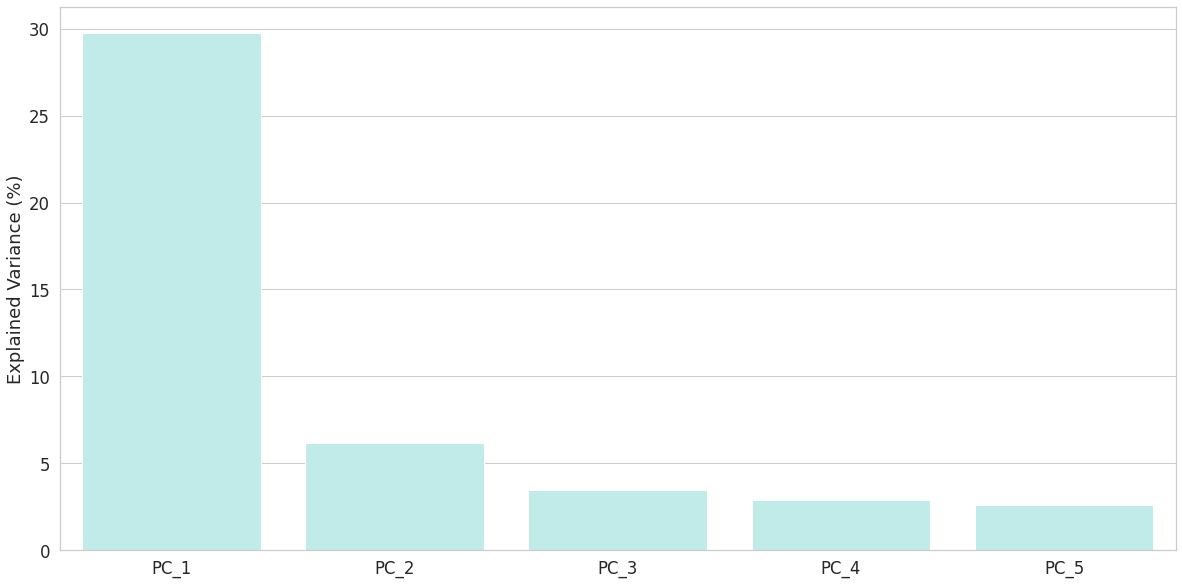

In [136]:
plt.figure(figsize = (20, 10))
sns.barplot(x = 'components', y = "variance", data = pca_explained, color = "c")

plt.xlabel('')
plt.ylabel('Explained Variance (%)');

In [ ]:
'''
pca_components['category'] = train_gene_matrix['pathways'].map(
    lambda x: x.split('_')[-1]) # Verificar!!

pca_components['is_nfkb'] = train_gene_matrix['pathways'].map(
    lambda x: True if x == 'nfkb_inhibitor' else False)

categorical = set(['cp_type', 'cp_time', 'cp_dose'])
for col in categorical:
  pca_components[col] = train_gene_matrix[col]
'''

In [195]:
pca_components[['pathways','cluster_name']] = train_gene_matrix[['pathways', 'cluster_name']]

In [196]:
pca_components.head(1)

,PC_1,PC_2,PC_3,PC_4,PC_5,cluster_name,pathways
0,-7.869299,-0.045199,-4.273462,3.909056,-1.195404,Cluster_9,gsk_inhibitor


In [335]:
pca_components[pca_components.pathways == 'nfkb_inhibitor'].head(1)

,PC_1,PC_2,PC_3,PC_4,PC_5,cluster_name,pathways
2395,52.632139,-10.2968,-6.942826,8.157872,19.749227,Cluster_40,nfkb_inhibitor


## 6.2. Are the PCs associated with any categorical feature?

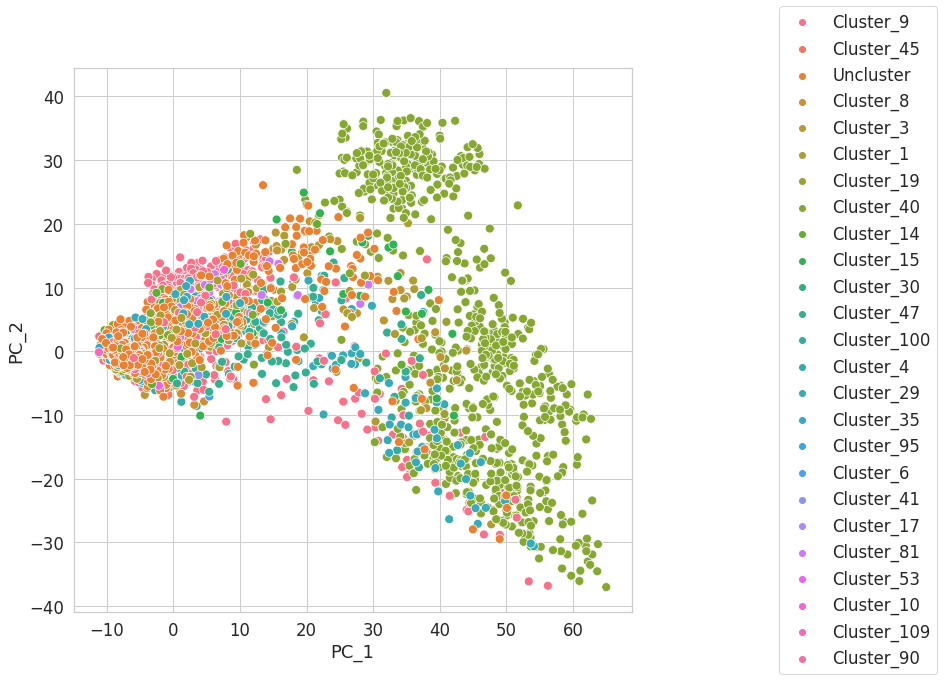

In [192]:
plt.figure(figsize = (10, 10))
fig.suptitle('Gene PCA per category')

c = sns.scatterplot(x = "PC_1", y = "PC_2", 
          data = pca_components, hue = 'cluster_name', # color by cluster 
          legend = True, s = 80) # specify the point size

c.legend(loc = 'center left', bbox_to_anchor = (1.25, 0.5), ncol = 1);

<AxesSubplot:xlabel='PC_1', ylabel='PC_2'>

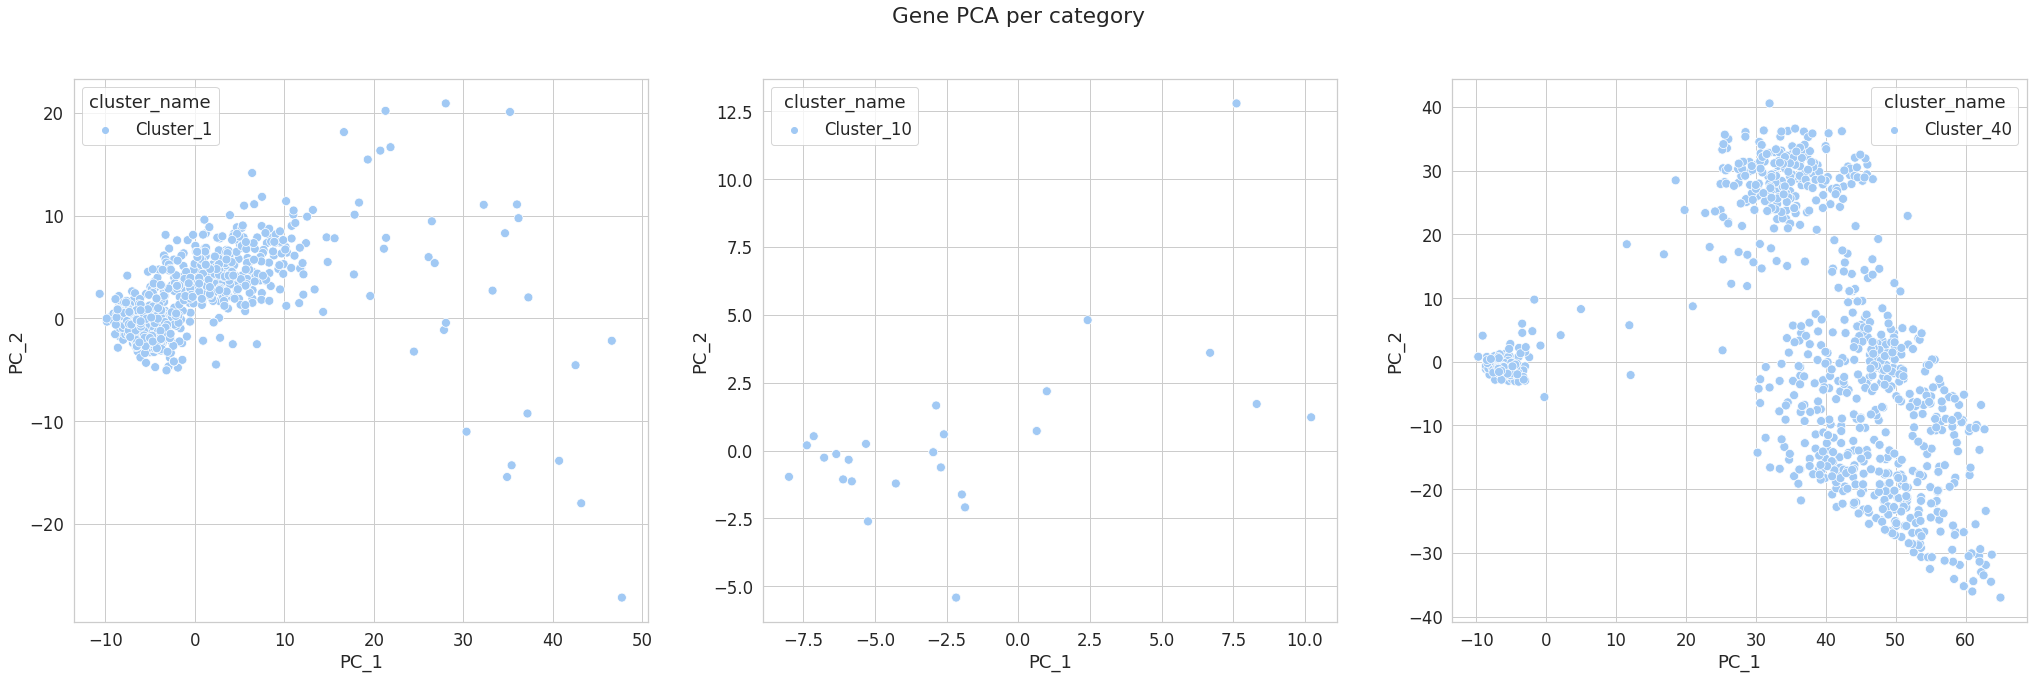

In [202]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (35, 10))
fig.suptitle('Gene PCA per category')

sns.scatterplot(x = "PC_1", y = "PC_2", 
          data = pca_components[pca_components.cluster_name == 'Cluster_1'], 
                hue = 'cluster_name', # color by cluster 
          legend = True, s = 80, ax = ax1) # specify the point size

sns.scatterplot(x = "PC_1", y = "PC_2", 
          data = pca_components[pca_components.cluster_name == 'Cluster_10'], 
                hue = 'cluster_name', # color by cluster 
          legend = True, s = 80, ax = ax2) # specify the point size

sns.scatterplot(x = "PC_1", y = "PC_2", 
          data = pca_components[pca_components.cluster_name == 'Cluster_40'], 
                hue = 'cluster_name', # color by cluster 
          legend = True, s = 80, ax = ax3) # specify the point size

## 6.3. Gene contributions in the PCs

In [278]:
components = pd.DataFrame(pca.components_, columns = gene_columns)

In [279]:
components['PCA'] = ['PCA_' + str(n) for n in range(1,6)]

In [280]:
components = pd.melt(components, id_vars = 'PCA')

In [282]:
components = components.groupby('PCA').apply(lambda x: x.sort_values('value', ascending = False))

In [317]:
components = components.assign(variance_threshold = [
    'Y' if var in train_pathway_variance.columns else 'N' for var in components['variable']])

In [327]:
components.head(15)

PCA variable     value variance_threshold
PCA                                                    
PCA_1 615   PCA_1    g-123  0.061846                  Y
      3720  PCA_1    g-744  0.061434                  Y
      1745  PCA_1    g-349  0.061418                  Y
      2300  PCA_1    g-460  0.060885                  Y
      1640  PCA_1    g-328  0.060724                  Y
      3655  PCA_1    g-731  0.060710                  Y
      2085  PCA_1    g-417  0.060606                  Y
      1240  PCA_1    g-248  0.060512                  Y
      655   PCA_1    g-131  0.059960                  Y
      190   PCA_1     g-38  0.059524                  Y
      1930  PCA_1    g-386  0.059334                  Y
      1305  PCA_1    g-261  0.059196                  Y
      735   PCA_1    g-147  0.059176                  Y
      1215  PCA_1    g-243  0.059082                  Y
      3560  PCA_1    g-712  0.058757                  Y

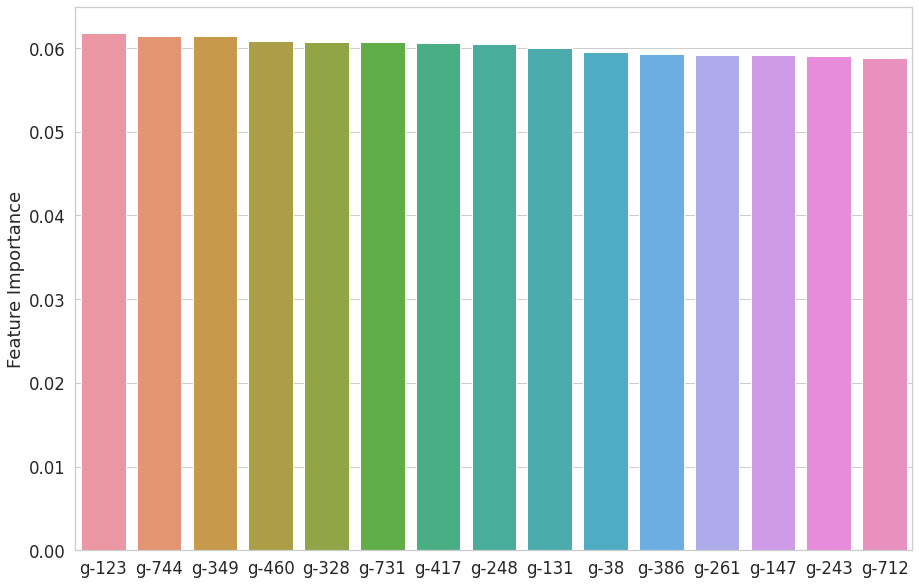

In [334]:
plt.figure(figsize = (15, 10))
sns.barplot(x = 'variable', y = 'value', data = components.head(15))

plt.ylabel('Feature Importance')
plt.xlabel('');

# 7. Dimensionality Reduction - t-SNE

In [203]:
tsne = TSNE(n_components = 2, random_state = 0)
tsne_obj = tsne.fit_transform(gene_scale)

In [207]:
tsne_df = pd.DataFrame({'X':tsne_obj[:,0], 'Y':tsne_obj[:,1], 
                        'cluster_name': train_gene_matrix['cluster_name']
                       })
tsne_df.head()

,X,Y,cluster_name
0,-8.236013,29.574385,Cluster_9
1,-19.720154,6.729316,Cluster_9
2,13.628382,-39.646519,Cluster_9
3,14.632914,-37.232082,Cluster_9
4,14.992095,-39.560734,Cluster_9


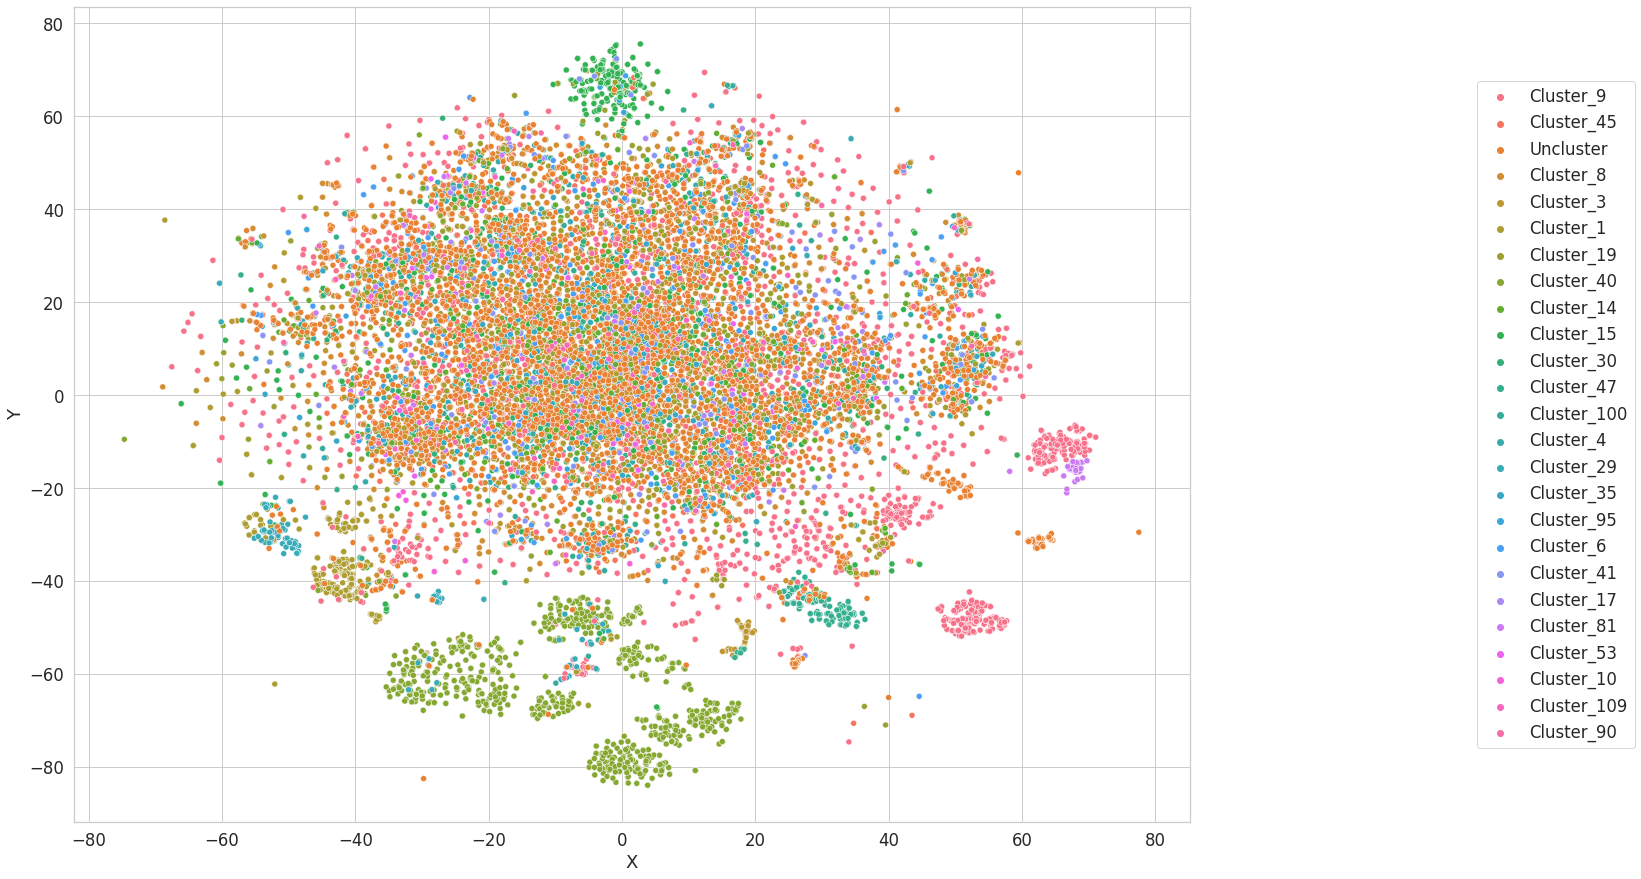

In [208]:
plt.figure(figsize = (20, 15))

t = sns.scatterplot(x = "X", y = "Y", hue = 'cluster_name', data = tsne_df);
t.legend(loc = 'center left', bbox_to_anchor = (1.25, 0.5), ncol = 1);

In [ ]:
# https://benalexkeen.com/principle-component-analysis-in-python/
# https://scikit-learn.org/stable/modules/model_evaluation.html